In [34]:
import tqdm as tqdm
from keras.models import *
from keras.layers import *
from keras.layers.convolutional import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils.np_utils import to_categorical
from torchvision.transforms import transforms
import math

### Collab code!

In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 5.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73050 sha256=c3a3318c750d9f47047a50ed2417dc8e27b9249a76761026d08f691d79782a84
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                  9KB  2022-10-06 08:55:25          11309        352  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset           11KB  2022-09-30 04:05:11           9025        285  1.0              
stetsondone/video-game-sales-by-genre                           Video Game Sales by Genre                        12KB  2022-10-31 17:56:01            838         23  1.0              
whenamancodes/credit-card-customers-prediction

In [5]:
!kaggle datasets download -d mostafaabla/garbage-classification -p /content/sample_data/ --unzip

100% 238M/239M [00:12<00:00, 21.8MB/s]
100% 239M/239M [00:12<00:00, 19.7MB/s]


In [35]:
#data processing
def read_and_resize(filename, grayscale = False, fx= 1, fy=1):
    if grayscale:
        img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
        img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result

#show images
def show_in_row(list_of_images, titles = None, disable_ticks = False):
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        if titles is not None:
            subplot.set_title(titles[idx])

        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.show()

#open txt file using path to the file and file_name.txt
def openWithTxt(txt: str, path:str):
    outData = []
    with open("/content/sample_data/"+txt) as f:
        for i in f.readlines():
            img ,classNum = i.split()
            classNum = int(classNum)
            img = read_and_resize(path+f"{deIdx[classNum]}/"+img).astype("float32")/255
            s = img.shape
            img = cv2.resize(img, (s[0],s[0]), interpolation = cv2.INTER_AREA)
            #outData.extend(rotate2sides(img, classNum))
            outData.append((img, classNum))
    return np.array(outData)

def openWith(dfX, dfY):
    outData = []
    for i in range(len(dfX)):
        path = "./sample_data/garbageAll/"
        img = dfX[i]
        classNum = dfY[i]
        img = read_and_resize(path+img).astype("float32")/255
        img = cv2.resize(img, (200,200), interpolation = cv2.INTER_AREA)
        outData.append((img, classNum))
    return np.array(outData)

# takes image ans its classNumber, and produce 4 rotaded images on exact degree (0, 90, 180, 270)
def rotate4sides(img, classNum):
    outData = []
    outData.append(np.array([img, classNum]))
    outData.append(np.array([cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE), classNum]))
    outData.append(np.array([cv2.rotate(img, cv2.ROTATE_180), classNum]))
    outData.append(np.array([cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE), classNum]))
    return outData

def rotate2sides(img, classNum):
    outData = []
    outData.append(np.array([img, classNum]))
    outData.append(np.array([cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE), classNum]))
    return outData

In [36]:
import os
import shutil

def moveToAll(neededDirs):
    pathTo   = "./sample_data/garbageAll/"
    pathFrom = "./sample_data/garbage_classification/"

    if not os.path.isdir(pathTo):
        os.mkdir(pathTo)
    else:
        shutil.rmtree(pathTo)
        os.mkdir(pathTo)

    for folder in neededDirs:
        print(len(os.listdir(pathFrom+folder)))
        for filename in os.listdir(pathFrom+folder):
            shutil.copy2(pathFrom+folder+"/"+filename, pathTo)

neededDirs = ["brown-glass", "cardboard", "green-glass", "plastic", "paper", "white-glass", "metal"]
moveToAll(neededDirs)

607
891
629
865
1050
775
769


#upload .csv in a folder


In [37]:
files.upload()

NameError: ignored

In [38]:
import pandas as pd
df = pd.read_csv("preprocessed_data.csv")
df

,photo,class
0,plastic200.jpg,3.0
1,cardboard456.jpg,1.0
2,metal104.jpg,2.0
3,white-glass53.jpg,4.0
4,cardboard820.jpg,1.0
...,...,...
5581,plastic429.jpg,3.0
5582,paper784.jpg,1.0
5583,brown-glass509.jpg,4.0
5584,cardboard827.jpg,1.0


In [39]:
from sklearn.model_selection import train_test_split

classDecode = {1:"paper/cardboard", 2: "metal", 3: "plastic", 4: "glass"}

x, x_test, y, y_test = train_test_split(df["photo"],df["class"],test_size=0.2,train_size=0.8)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.20,train_size =0.80)


In [40]:
x_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)
x_train.reset_index(inplace=True, drop=True)
x_cv.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_cv.reset_index(inplace=True, drop=True)

In [41]:
y_test

0       4.0
1       3.0
2       4.0
3       4.0
4       4.0
       ... 
1113    4.0
1114    4.0
1115    1.0
1116    1.0
1117    3.0
Name: class, Length: 1118, dtype: float64

In [42]:
testData = openWith(x_test, y_test)
xTest = np.stack(testData[:,0])
yTest =  to_categorical(testData[:,1],num_classes = len(classDecode.values())+1)[:,1:]
testData.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(1118, 2)

In [43]:
trainData = openWith(x_train, y_train)
xTrain = np.stack(trainData[:,0])
yTrain = to_categorical(trainData[:,1],num_classes = len(classDecode.values())+1)[:,1:]
trainData.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(3574, 2)

In [44]:
valData = openWith(x_cv, y_cv)
xVal = np.stack(valData[:,0])
yVal = to_categorical(valData[:,1],num_classes = len(classDecode.values())+1)[:,1:]
valData.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(894, 2)

In [45]:
yTrain.shape

(3574, 4)

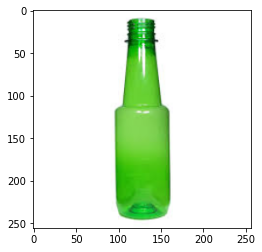

In [46]:
for i in range(len(x_test)):
    path = "./sample_data/garbageAll/"
    img = x_test[i]
    img = read_and_resize(path+img).astype("float32")/255
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
    show_in_row([img])
    break

        

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


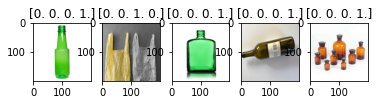

In [47]:
show_in_row(xTest[:5], yTest[:5])

# Model 1

##  CNN (keras)


# model

# model pytorch

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
import torchvision.models as models

In [49]:
#output - vector of vectors, labels - vactor
def accuracy(outputs, labels):
    return torch.tensor(torch.sum(outputs.argmax(1) == labels.argmax(1)).item() / len(labels))

#implement Base for Classification
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        #print(batch.shape)
        #print()
        #batch - (img, label)
        self.train() 
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        #batch - (img, label)
        self.eval() 
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        

    def validation_epoch_end(self, outputs):
        #outputs - list of dicts of validations 
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch {epoch+1}: train_loss: {result['train_loss']}, val_loss: {result['val_loss']}, val_acc: {result['val_acc']}")

class ImageClassificationInception(nn.Module):
    def training_step(self, batch):
        #print(batch.shape)
        #print()
        #batch - (img, label)
        self.train() 
        images, labels = batch 
        outputs = self(images) 
        loss1 = F.cross_entropy(outputs, labels)
        loss = loss1
        return loss
    
    def validation_step(self, batch):
        #batch - (img, label)
        self.eval() 
        images, labels = batch 
        outputs = self(images) 
        loss1 = F.cross_entropy(outputs, labels)
        loss = loss1
        acc = accuracy(outputs, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        

    def validation_epoch_end(self, outputs):
        #outputs - list of dicts of validations 
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch {epoch+1}: train_loss: {result['train_loss']}, val_loss: {result['val_loss']}, val_acc: {result['val_acc']}")

In [50]:

class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(classDecode.values()))
    
    def forward(self, xb):
        o = self.network(xb)
        return F.softmax(o)

class DenseNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.densenet121(pretrained=True)
        self.network.classifier = nn.Linear(1024, len(classDecode.values()))
    
    def forward(self, xb):
        o = self.network(xb)
        return F.softmax(o)

class InceptionNet(ImageClassificationInception):
    def __init__(self):
        super().__init__()
        self.network = models.inception_v3(pretrained=True)
        self.network.aux_logits=False
        num_ftrs = self.network.AuxLogits.fc.in_features
        self.network.AuxLogits.fc = nn.Linear(num_ftrs, len(classDecode.values()))
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs,len(classDecode.values()))
    
    def forward(self, xb):
        o = self.network(xb)
        return F.softmax(o)


class VGGNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.vgg16(pretrained=True)
        # Replace last layer
        self.network.classifier[6] = torch.nn.Linear(4096, len(classDecode.values()))
    
    def forward(self, xb):
        o = self.network(xb)
        return F.softmax(o)

class Net(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(16, 16, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(16, 32, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 4 * 4 , 128)
        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return F.softmax(x)


In [51]:
torch.cuda.empty_cache()

In [52]:
from torch.utils.data import Dataset


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, x, device, len):
        self.dl = x
        self.device = device
        self.len = len
        
    def __iter__(self):
        for item in self.dl: 
            yield to_device(item, self.device)

    def __len__(self):
        return self.len

class MyData(Dataset):
    def __init__(self, x, y, transform):
        self.x = x
        self.y = y
        self.transform = transform
        self.len = len(x)
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return self.len
    def __getitem__(self, item):
        #print(type(self.x[item]))
        return self.transform(self.x[item]), torch.from_numpy(self.y[item])

device = get_default_device()
device

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
batch_size = 32

print(xTrain.shape)
print(yTrain.shape)


myDataTrain = MyData(xTrain,yTrain, transform)
myDataVal = MyData(xVal,yVal, transform)
myDataTest = MyData(xTest,yTest, transform)

dataTrain = torch.utils.data.DataLoader(myDataTrain, batch_size=batch_size)
dataVal = torch.utils.data.DataLoader(myDataVal, batch_size=batch_size)
dataTest = torch.utils.data.DataLoader(myDataTest, batch_size=batch_size)

dataTrain = DeviceDataLoader(dataTrain, device,len(yTrain))
dataVal = DeviceDataLoader(dataVal, device,len(yVal))
dataTest = DeviceDataLoader(dataTest, device,len(yTest))



(3574, 200, 200, 3)
(3574, 4)


In [53]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Inception

In [19]:
model = to_device(InceptionNet(), device)
evaluate(model, dataTest)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'val_loss': 1.3963111639022827, 'val_acc': 0.23077382147312164}

In [20]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, dataTrain, dataVal, opt_func)

RuntimeError: ignored

In [ ]:
evaluate(model, dataTest)

In [ ]:
del(model)

# DenseNet


In [54]:
model = to_device(DenseNet(), device)
evaluate(model, dataTest)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'val_loss': 1.393370509147644, 'val_acc': 0.20029762387275696}

In [55]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5 

history = fit(num_epochs, lr, model, dataTrain, dataVal, opt_func)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: train_loss: 0.9890915155410767, val_loss: 0.8386875987052917, val_acc: 0.9453125
Epoch 2: train_loss: 0.8095247149467468, val_loss: 0.8061172366142273, val_acc: 0.953125
Epoch 3: train_loss: 0.7671505212783813, val_loss: 0.7964967489242554, val_acc: 0.9587053656578064
Epoch 4: train_loss: 0.7543915510177612, val_loss: 0.7905411124229431, val_acc: 0.9598214030265808
Epoch 5: train_loss: 0.7501395344734192, val_loss: 0.7881098389625549, val_acc: 0.9631696343421936
Epoch 6: train_loss: 0.7480021119117737, val_loss: 0.7857857346534729, val_acc: 0.9642857313156128
Epoch 7: train_loss: 0.746627151966095, val_loss: 0.785795271396637, val_acc: 0.9631696343421936
Epoch 8: train_loss: 0.7462127208709717, val_loss: 0.7851431369781494, val_acc: 0.9642857313156128
Epoch 9: train_loss: 0.7461793422698975, val_loss: 0.7854726314544678, val_acc: 0.9631696343421936
Epoch 10: train_loss: 0.7459458112716675, val_loss: 0.7847047448158264, val_acc: 0.9620535969734192


In [56]:
evaluate(model, dataTest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'val_loss': 0.7888217568397522, 'val_acc': 0.9544642567634583}

In [57]:
del(model)

# ResNet

In [61]:
model = to_device(ResNet(), device)
evaluate(model, dataTest)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


{'val_loss': 1.3815927505493164, 'val_acc': 0.23726190626621246}

In [62]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5 

history = fit(num_epochs, lr, model, dataTrain, dataVal, opt_func)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch 1: train_loss: 0.920762300491333, val_loss: 0.8073042035102844, val_acc: 0.9453125
Epoch 2: train_loss: 0.7845194935798645, val_loss: 0.8051995635032654, val_acc: 0.9386160969734192
Epoch 3: train_loss: 0.7670024037361145, val_loss: 0.7919043302536011, val_acc: 0.9542410969734192
Epoch 4: train_loss: 0.7576763033866882, val_loss: 0.7860565781593323, val_acc: 0.9598214030265808
Epoch 5: train_loss: 0.7519763708114624, val_loss: 0.7847854495048523, val_acc: 0.9553571343421936
Epoch 6: train_loss: 0.7516723871231079, val_loss: 0.7830186486244202, val_acc: 0.9609375
Epoch 7: train_loss: 0.7507798671722412, val_loss: 0.7796981334686279, val_acc: 0.9619792103767395
Epoch 8: train_loss: 0.748507559299469, val_loss: 0.7801950573921204, val_acc: 0.9665178656578064
Epoch 9: train_loss: 0.748406708240509, val_loss: 0.7927884459495544, val_acc: 0.9519345164299011
Epoch 10: train_loss: 0.750078558921814, val_loss: 0.792548418045044, val_acc: 0.9508928656578064


In [63]:
evaluate(model, dataTest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


{'val_loss': 0.7967091202735901, 'val_acc': 0.9445833563804626}

In [64]:
del(model)

# VGG


In [58]:
model3 = to_device(VGGNet(), device)
evaluate(model3, dataTest)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'val_loss': 1.3746545314788818, 'val_acc': 0.3095238208770752}

In [59]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 5.5e-5 

history = fit(num_epochs, lr, model3, dataTrain, dataVal, opt_func)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: train_loss: 0.9677273631095886, val_loss: 0.8717265725135803, val_acc: 0.8646577596664429
Epoch 2: train_loss: 0.84929358959198, val_loss: 0.8476076722145081, val_acc: 0.8925595283508301
Epoch 3: train_loss: 0.8223062753677368, val_loss: 0.8415981531143188, val_acc: 0.8982142806053162
Epoch 4: train_loss: 0.8051403760910034, val_loss: 0.856124222278595, val_acc: 0.888244092464447
Epoch 5: train_loss: 0.7976633906364441, val_loss: 0.8913146257400513, val_acc: 0.8511160612106323
Epoch 6: train_loss: 0.7992236614227295, val_loss: 0.8433651328086853, val_acc: 0.896056592464447
Epoch 7: train_loss: 0.7842244505882263, val_loss: 0.7988829016685486, val_acc: 0.9418154954910278
Epoch 8: train_loss: 0.7712522745132446, val_loss: 0.8109492063522339, val_acc: 0.9317708611488342
Epoch 9: train_loss: 0.7673804759979248, val_loss: 0.8073222041130066, val_acc: 0.9340029954910278
Epoch 10: train_loss: 0.7665198445320129, val_loss: 0.8047615885734558, val_acc: 0.9407738447189331
Epoch 11: trai

In [60]:
evaluate(model3, dataTest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'val_loss': 0.8236653208732605, 'val_acc': 0.917738139629364}

In [65]:
del(model3)

# MyLittleModel

In [ ]:
model2 = to_device(Net(), device)
evaluate(model2, dataTest)

In [ ]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 5.5e-5 

history = fit(num_epochs, lr, model2, dataTrain, dataVal, opt_func)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: train_loss: 1.5985661745071411, val_loss: 1.59907865524292, val_acc: 0.43465909361839294
Epoch 2: train_loss: 1.5879095792770386, val_loss: 1.5929450988769531, val_acc: 0.4517045319080353
Epoch 3: train_loss: 1.582120656967163, val_loss: 1.5874441862106323, val_acc: 0.4545454680919647
Epoch 4: train_loss: 1.576361060142517, val_loss: 1.5819647312164307, val_acc: 0.4630681872367859
Epoch 5: train_loss: 1.5712506771087646, val_loss: 1.5773649215698242, val_acc: 0.47159090638160706
Epoch 6: train_loss: 1.5662802457809448, val_loss: 1.5726343393325806, val_acc: 0.47159090638160706
Epoch 7: train_loss: 1.560564398765564, val_loss: 1.5653364658355713, val_acc: 0.4857954680919647
Epoch 8: train_loss: 1.553512454032898, val_loss: 1.569851279258728, val_acc: 0.4943181872367859
Epoch 9: train_loss: 1.546003818511963, val_loss: 1.5616538524627686, val_acc: 0.5056818127632141
Epoch 10: train_loss: 1.5410611629486084, val_loss: 1.5586732625961304, val_acc: 0.5
Epoch 11: train_loss: 1.53717

In [ ]:
evaluate(model2, dataTest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'val_loss': 1.5115759372711182, 'val_acc': 0.524404764175415}

In [ ]:
list(dataTest)[0][1].argmax(1)

tensor([1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 3, 3, 2, 2, 4, 4,
        0, 0, 1, 1, 2, 2, 3, 3, 2, 2, 1, 1, 1, 1, 2, 2, 0, 0, 5, 5, 3, 3, 2, 2,
        3, 3, 4, 4, 4, 4, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 1, 1, 2, 2,
        3, 3, 0, 0, 1, 1, 0, 0, 2, 2, 5, 5, 5, 5, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 0, 0, 5, 5, 4, 4, 4, 4, 2, 2, 3, 3,
        1, 1, 1, 1, 3, 3, 3, 3], device='cuda:0')

In [ ]:
model(list(dataTest)[0][0]).argmax(1)

TypeError: ignored

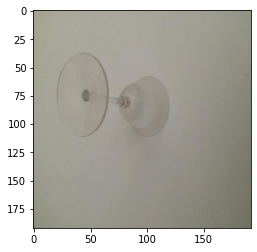

In [ ]:
show_in_row([xTest[6]])

In [ ]:
deIdx

{1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}

In [ ]:
tIdx = 6 
labelTrue = yTest[tIdx]


In [ ]:
model(torch.tensor(xTest[6].transpose([2,0,1])).unsqueeze(0).to(device))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[9.9920e-01, 3.7047e-04, 5.8046e-05, 3.0478e-04, 1.1301e-05, 5.7821e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

array([[[0.6421569 , 0.6303922 , 0.55588233],
        [0.63725495, 0.6254902 , 0.55098045],
        [0.63823533, 0.6264706 , 0.5519608 ],
        ...,
        [0.5715686 , 0.57549024, 0.5137255 ],
        [0.5686275 , 0.57254905, 0.5019608 ],
        [0.5627451 , 0.5666667 , 0.49607843]],

       [[0.63823533, 0.6264706 , 0.5519608 ],
        [0.64705884, 0.63529414, 0.56078434],
        [0.63823533, 0.6264706 , 0.5519608 ],
        ...,
        [0.5627451 , 0.5666667 , 0.5019608 ],
        [0.5686275 , 0.57254905, 0.5019608 ],
        [0.57450986, 0.5784314 , 0.50784314]],

       [[0.6362745 , 0.6245098 , 0.55      ],
        [0.6529412 , 0.64117646, 0.5666667 ],
        [0.64607847, 0.63431376, 0.55980396],
        ...,
        [0.5627451 , 0.5666667 , 0.5019608 ],
        [0.5686275 , 0.57254905, 0.5019608 ],
        [0.57450986, 0.5784314 , 0.50784314]],

       ...,

       [[0.4764706 , 0.48431373, 0.3882353 ],
        [0.5529412 , 0.56078434, 0.4745098 ],
        [0.5588236 , 0